In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lv import *

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

from flux import *
from xsec import *

from scipy.integrate import quad
from scipy.interpolate import interp1d,interp2d



In [3]:

# neutrino flavors
alpha = "e"
beta = "e"

In [4]:
Nbaselines = 100
Nenergies = 100
#baselines = np.logspace(1,4.1,Nbaselines)*1e3
baselines = np.logspace(0, np.log10(6.371*2), Nbaselines)*1e6
#energies = np.logspace(-1,3,Nenergies)*1e9
energies = np.logspace(np.log10(Emuon/10), np.log10(Emuon), Nenergies+1)[:-1] * 1e9
SM_cases = []
for baseline in baselines:
    SM_case = LV_oscillations(energies, baseline, 1)
    SM_cases.append(SM_case)

In [5]:
osc_probs_SM = np.zeros((Nbaselines,Nenergies))
for ibaseline,SM_case in enumerate(SM_cases):
    osc_probs_SM[ibaseline,:] = SM_case.get_oscillation_probability(alpha, beta)

In [6]:
# lorentz violation parameters
aeu=0#3e-24*1e9
aet=0#1e-23*1e9
aut=0#3e-24*1e9
ceu=0#1e-27
cet=1e-26
cut=1e-27
LV_cases = []
for baseline in baselines:
    LV_case = LV_oscillations(energies, baseline, 1,
                              aeu = aeu, aet = aet, aut = aut,
                              ceu = ceu, cet = cet, cut = cut)
    LV_cases.append(LV_case)

In [7]:

osc_probs = np.zeros((Nbaselines,Nenergies))
for ibaseline,LV_case in enumerate(LV_cases):
    osc_probs[ibaseline,:] = LV_case.get_oscillation_probability(alpha, beta)


1.0 -26 0.0 0
1.0 -27 0.0 0


Text(614.1767519298115, 6824.54818, 'Chicago\n$\\to$KM3Net')

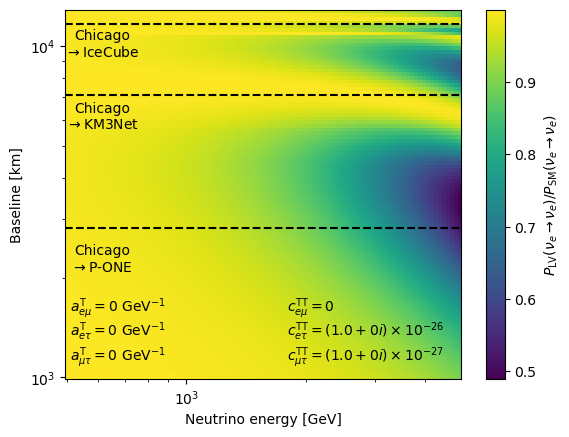

In [8]:
plt.pcolormesh(energies/1e9,baselines/1e3,osc_probs/osc_probs_SM)
plt.loglog()
c = plt.colorbar()
plt.xlabel(r"Neutrino energy [GeV]")
plt.ylabel(r"Baseline [km]")
c.set_label(r"$P_{\rm LV}(\nu_%s \to \nu_%s)/P_{\rm SM}(\nu_%s \to \nu_%s)$"%(alpha,beta,alpha,beta))
text_heights = np.linspace(3.05,3.2,3)
text_x_a,text_x_c = 510,1800
plt.text(text_x_a,10**text_heights[2],r"$a^{\rm T}_{e \mu} = %s~{\rm GeV}^{-1}$"%(sci_notation(aeu/1e9) if np.abs(aeu)>0 else "0"))
plt.text(text_x_a,10**text_heights[1],r"$a^{\rm T}_{e \tau} = %s~{\rm GeV}^{-1}$"%(sci_notation(aet/1e9) if np.abs(aet)>0 else "0"))
plt.text(text_x_a,10**text_heights[0],r"$a^{\rm T}_{\mu \tau} = %s~{\rm GeV}^{-1}$"%(sci_notation(aut/1e9) if np.abs(aut)>0 else "0"))
plt.text(text_x_c,10**text_heights[2],r"$c^{\rm TT}_{e \mu} = %s$"%(sci_notation(ceu) if np.abs(ceu)>0 else "0"))
plt.text(text_x_c,10**text_heights[1],r"$c^{\rm TT}_{e \tau} = %s$"%(sci_notation(cet) if np.abs(cet)>0 else "0"))
plt.text(text_x_c,10**text_heights[0],r"$c^{\rm TT}_{\mu \tau} = %s$"%(sci_notation(cut) if np.abs(cut)>0 else "0"))

plt.axhline(ICECUBE_BASELINE/1e3, color="black", linestyle="--")
plt.axhline(PONE_BASELINE/1e3, color="black", linestyle="--")
plt.axhline(KM3NeT_BASELINE/1e3, color="black", linestyle="--")

plt.text(plt.xlim()[0] + 120, ICECUBE_BASELINE/1e3 - 300,'Chicago\n$\\to$IceCube', verticalalignment="top", horizontalalignment="center")
plt.text(plt.xlim()[0] + 120, PONE_BASELINE/1e3 - 300,'Chicago\n$\\to$P-ONE', verticalalignment="top", horizontalalignment="center")
plt.text(plt.xlim()[0] + 120, KM3NeT_BASELINE/1e3 - 300,'Chicago\n$\\to$KM3Net', verticalalignment="top", horizontalalignment="center")

# Rate calculations under different hypotheses

In [9]:
# Rate of neutrino interactions / dR / dE
# Units: (Number of Interactions) / m / GeV
def rate(flux, xsec, Enu, R, P, baseline):
    costh = np.cos(R/baseline)
    ret = flux(Emuon, P, Enu, costh, baseline)*xsec(Enu)*MASS*(4*np.pi*R*np.sqrt(RADIUS**2 - R**2)/VOLUME)
    if not isinstance(ret, float):
        ret[R > RADIUS] = 0
    elif R > RADIUS:
        return 0
    return ret

def numu_rate(Enu, R, P, B):
    return rate(numu_flux_baseline, xsec, Enu, R, P, B)

def nue_rate(Enu, R, P, B):
    return rate(nue_flux_baseline, xsec, Enu, R, P, B)

def numubar_rate(Enu, R, P, B):
    return rate(numu_flux_baseline, xsecbar, Enu, R, P, B)

def nuebar_rate(Enu, R, P, B):
    return rate(nue_flux_baseline, xsecbar, Enu, R, P, B)

In [10]:
Enu = np.linspace(Emuon/100, Emuon, 100)
Rs = np.linspace(0,RADIUS,100)

In [11]:
rates_per_energy = {}
rates_per_radius_SM = {}
rates_per_radius_LV = {}
rate_functions = {}
experiment_list = ["KM3","IC","PONE"]
particle_list = ["numubar","nue"]
baseline_list = {"PONE":PONE_BASELINE,
                 "KM3":KM3NeT_BASELINE,
                 "IC":ICECUBE_BASELINE}
LV_case_list = {}
SM_case_list = {}
for experiment in experiment_list:
    LV_case_list[("nu",experiment)] = LV_oscillations(Enu*1e9, baseline_list[experiment], 1,
                                                      aeu = aeu, aet = aet, aut = aut,
                                                      ceu = ceu, cet = cet, cut = cut)
    LV_case_list[("nubar",experiment)] = LV_oscillations(Enu*1e9, baseline_list[experiment], -1,
                                                      aeu = aeu, aet = aet, aut = aut,
                                                      ceu = ceu, cet = cet, cut = cut)
    SM_case_list[("nu",experiment)] = LV_oscillations(Enu*1e9, baseline_list[experiment], 1,
                                                      aeu = 0, aet = 0, aut = 0,
                                                      ceu = 0, cet = 0, cut = 0)
    SM_case_list[("nubar",experiment)] = LV_oscillations(Enu*1e9, baseline_list[experiment], -1,
                                                      aeu = 0, aet = 0, aut = 0,
                                                      ceu = 0, cet = 0, cut = 0)
for particle,rate_function in zip(["numu","numubar","nue","nuebar"],
                                  [numu_rate,numubar_rate,nue_rate,nuebar_rate]):
    rate_functions[particle] = rate_function
    for experiment in experiment_list:
        rates_per_energy[(particle,experiment)] = np.zeros(Enu.shape)
        rates_per_radius_SM[(particle,experiment)] = np.zeros(Rs.shape)
        rates_per_radius_LV[(particle,experiment)] = np.zeros(Rs.shape)


for particle in particle_list:
    for experiment in experiment_list:
        for i,E in enumerate(Enu):
            rates_per_energy[(particle,experiment)][i] = quad(lambda R: rate_functions[particle](E, R, P, baseline_list[experiment]), 0, RADIUS)[0]

# now do the radial distributions
for experiment in experiment_list:
    for i, R in enumerate(Rs):
        SM_mu_mu_osc = interp1d(Enu, SM_case_list[("nubar",experiment)].get_oscillation_probability("mu","mu",R=R))
        SM_mu_e_osc = interp1d(Enu, SM_case_list[("nubar",experiment)].get_oscillation_probability("mu","e",R=R))
        SM_e_e_osc = interp1d(Enu, SM_case_list[("nu",experiment)].get_oscillation_probability("e","e",R=R))
        SM_e_mu_osc = interp1d(Enu, SM_case_list[("nu",experiment)].get_oscillation_probability("e","mu",R=R))
        LV_mu_mu_osc = interp1d(Enu, LV_case_list[("nubar",experiment)].get_oscillation_probability("mu","mu",R=R))
        LV_mu_e_osc = interp1d(Enu, LV_case_list[("nubar",experiment)].get_oscillation_probability("mu","e",R=R))
        LV_e_e_osc = interp1d(Enu, LV_case_list[("nu",experiment)].get_oscillation_probability("e","e",R=R))
        LV_e_mu_osc = interp1d(Enu, LV_case_list[("nu",experiment)].get_oscillation_probability("e","mu",R=R))
        rates_per_radius_SM[("numubar",experiment)][i] = quad(lambda E: rate_functions["numubar"](E, R, P, baseline_list[experiment]) * SM_mu_mu_osc(E) + rate_functions["nue"](E, R, P, baseline_list[experiment]) * SM_e_mu_osc(E), Enu[0], Enu[-1])[0]
        rates_per_radius_SM[("nue",experiment)][i] = quad(lambda E: rate_functions["nue"](E, R, P, baseline_list[experiment]) * SM_e_e_osc(E) + rate_functions["numubar"](E, R, P, baseline_list[experiment]) * SM_mu_e_osc(E), Enu[0], Enu[-1])[0]
        rates_per_radius_LV[("numubar",experiment)][i] = quad(lambda E: rate_functions["numubar"](E, R, P, baseline_list[experiment]) * LV_mu_mu_osc(E) + rate_functions["nue"](E, R, P, baseline_list[experiment]) * LV_e_mu_osc(E), Enu[0], Enu[-1])[0]
        rates_per_radius_LV[("nue",experiment)][i] = quad(lambda E: rate_functions["nue"](E, R, P, baseline_list[experiment]) * LV_e_e_osc(E) + rate_functions["numubar"](E, R, P, baseline_list[experiment]) * LV_mu_e_osc(E), Enu[0], Enu[-1])[0]
        
        

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_1915/3068576.py:37: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rates_per_energy[(particle,experiment)][i] = quad(lambda R: rate_functions[particle](E, R, P, baseline_list[experiment]), 0, RADIUS)[0]
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_1915/3068576.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rates_per_energy[(particle,experiment)][i] = quad(lambda R: rate_functions[part

# Energy Distributions

1.0 -26 0.0 0


/Users/nickkamp/Documents/Harvard/Research/Fun/Gray_MuonColliderIceCube/NuTelescopeMuCollider/lv.py:125: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(Enu/1e3,rates_per_energy_LV[experiment]/rates_per_energy_SM[experiment],color=color)


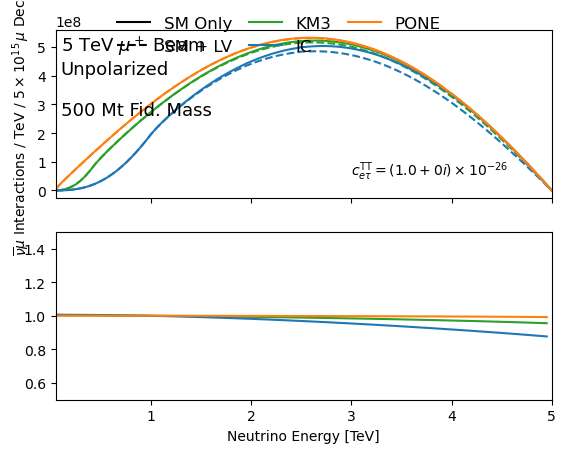

1.0 -26 0.0 0


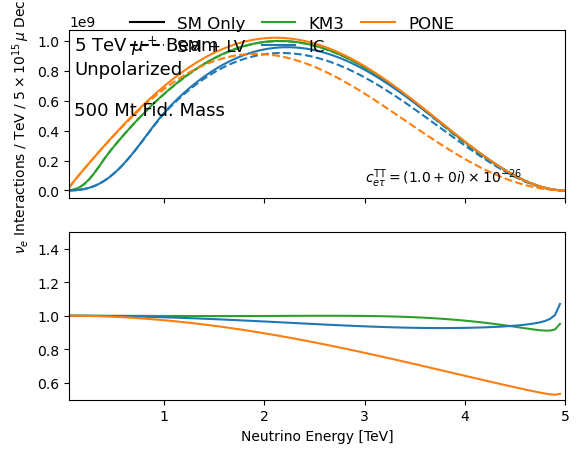

In [12]:
numubar_rates_per_energy_SM = {}
numubar_rates_per_energy_LV = {}
nue_rates_per_energy_SM = {}
nue_rates_per_energy_LV = {}

for experiment in experiment_list:
    numubar_rate = rates_per_energy[("numubar",experiment)]
    nue_rate = rates_per_energy[("nue",experiment)]

    # numubars
    mu_to_mu_LV = LV_case_list[("nubar",experiment)].get_oscillation_probability("mu", "mu") * numubar_rate
    mu_to_mu_SM = SM_case_list[("nubar",experiment)].get_oscillation_probability("mu", "mu") * numubar_rate
    e_to_mu_LV = LV_case_list[("nu",experiment)].get_oscillation_probability("e", "mu") * nue_rate
    e_to_mu_SM = SM_case_list[("nu",experiment)].get_oscillation_probability("e", "mu") * nue_rate
    numubar_rates_per_energy_SM[experiment] = mu_to_mu_SM + e_to_mu_SM
    numubar_rates_per_energy_LV[experiment] = mu_to_mu_LV + e_to_mu_LV

    # nues
    mu_to_e_LV = LV_case_list[("nubar",experiment)].get_oscillation_probability("mu", "e") * numubar_rate
    mu_to_e_SM = SM_case_list[("nubar",experiment)].get_oscillation_probability("mu", "e") * numubar_rate
    e_to_e_LV = LV_case_list[("nu",experiment)].get_oscillation_probability("e", "e") * nue_rate
    e_to_e_SM = SM_case_list[("nu",experiment)].get_oscillation_probability("e", "e") * nue_rate
    nue_rates_per_energy_SM[experiment] = mu_to_e_SM + e_to_e_SM
    nue_rates_per_energy_LV[experiment] = mu_to_e_LV + e_to_e_LV
    
energy_plot_1D(Enu,Emuon,
               experiment_list,
               numubar_rates_per_energy_SM,
               numubar_rates_per_energy_LV,
               r"\overline{\nu}\mu",cet=cet)

energy_plot_1D(Enu,Emuon,
               experiment_list,
               nue_rates_per_energy_SM,
               nue_rates_per_energy_LV,
               r"\nu_e",cet=cet)


# Radius

1.0 -26 0.0 0


/Users/nickkamp/Documents/Harvard/Research/Fun/Gray_MuonColliderIceCube/NuTelescopeMuCollider/lv.py:167: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(Rs,rates_per_radius_LV[(nutype,experiment)]/rates_per_radius_SM[(nutype,experiment)],color=color)


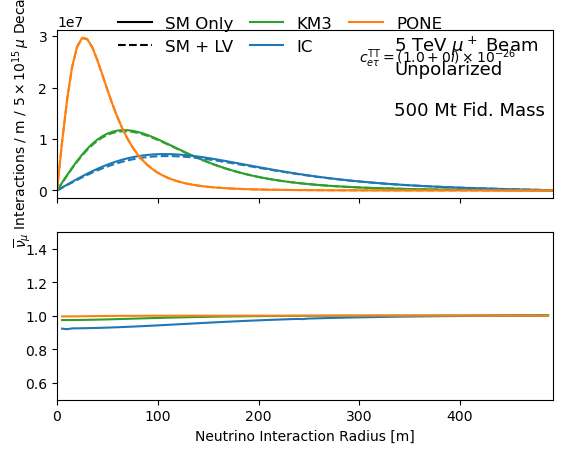

1.0 -26 0.0 0


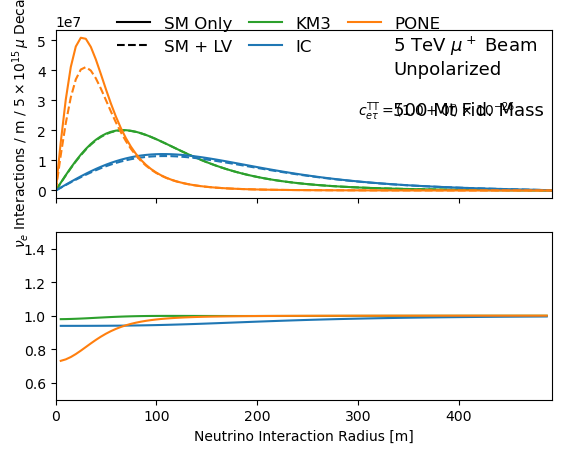

In [13]:
# numubars
radial_plot_1D(Rs,Emuon,
               experiment_list,
               rates_per_radius_SM,
               rates_per_radius_LV,
               "numubar",r"\overline{\nu}_\mu",
               cet=cet)
radial_plot_1D(Rs,Emuon,
               experiment_list,
               rates_per_radius_SM,
               rates_per_radius_LV,
               "nue",r"\nu_e",
               cet=cet)
               

# 2D binned distribution

In [14]:
numubar_rates_per_energy_radius_SM = {}
numubar_rates_per_energy_radius_LV = {}
nue_rates_per_energy_radius_SM = {}
nue_rates_per_energy_radius_LV = {}

numubar_rate = rate_functions['numubar']
nue_rate = rate_functions['nue']

for experiment in experiment_list:
    numubar_rates_per_energy_radius_SM[experiment] = np.zeros((len(Enu),len(Rs)))
    numubar_rates_per_energy_radius_LV[experiment] = np.zeros((len(Enu),len(Rs)))
    nue_rates_per_energy_radius_SM[experiment] = np.zeros((len(Enu),len(Rs)))
    nue_rates_per_energy_radius_LV[experiment] = np.zeros((len(Enu),len(Rs)))
    
    for ir,R in enumerate(Rs):
        # numubars
        mu_to_mu_LV = LV_case_list[("nubar",experiment)].get_oscillation_probability("mu", "mu",R=R)
        mu_to_mu_SM = SM_case_list[("nubar",experiment)].get_oscillation_probability("mu", "mu",R=R)
        e_to_mu_LV = LV_case_list[("nu",experiment)].get_oscillation_probability("e", "mu",R=R)
        e_to_mu_SM = SM_case_list[("nu",experiment)].get_oscillation_probability("e", "mu",R=R)
    
        # nues
        mu_to_e_LV = LV_case_list[("nubar",experiment)].get_oscillation_probability("mu", "e",R=R)
        mu_to_e_SM = SM_case_list[("nubar",experiment)].get_oscillation_probability("mu", "e",R=R)
        e_to_e_LV = LV_case_list[("nu",experiment)].get_oscillation_probability("e", "e",R=R)
        e_to_e_SM = SM_case_list[("nu",experiment)].get_oscillation_probability("e", "e",R=R)
        for ie,E in enumerate(Enu):
            numubar_rates_per_energy_radius_SM[experiment][ie,ir] = mu_to_mu_SM[ie] * numubar_rate(E, R, P, baseline_list[experiment]) + e_to_mu_SM[ie] * nue_rate(E, R, P, baseline_list[experiment])
            numubar_rates_per_energy_radius_LV[experiment][ie,ir] = mu_to_mu_LV[ie] * numubar_rate(E, R, P, baseline_list[experiment]) + e_to_mu_LV[ie] * nue_rate(E, R, P, baseline_list[experiment])
            nue_rates_per_energy_radius_SM[experiment][ie,ir] = e_to_e_SM[ie] * nue_rate(E, R, P, baseline_list[experiment]) + mu_to_e_SM[ie] * numubar_rate(E, R, P, baseline_list[experiment])
            nue_rates_per_energy_radius_LV[experiment][ie,ir] = e_to_e_LV[ie] * nue_rate(E, R, P, baseline_list[experiment]) + mu_to_e_LV[ie] * numubar_rate(E, R, P, baseline_list[experiment])
            
            
        
        

KM3


/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_1915/2749635512.py:2: RuntimeWarning: invalid value encountered in divide
  numubar_ratio = numubar_rates_per_energy_radius_LV[experiment]/numubar_rates_per_energy_radius_SM[experiment]
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_1915/2749635512.py:3: RuntimeWarning: invalid value encountered in divide
  nue_ratio = nue_rates_per_energy_radius_LV[experiment]/nue_rates_per_energy_radius_SM[experiment]


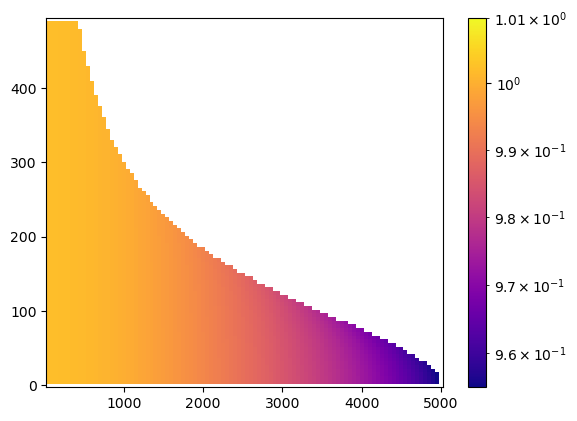

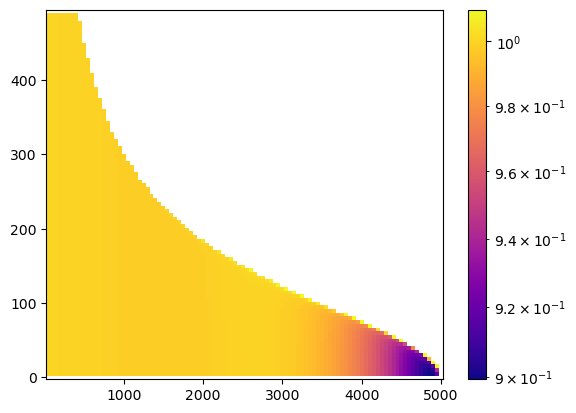

IC


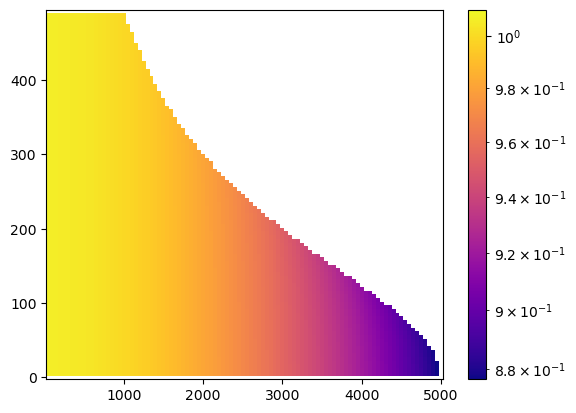

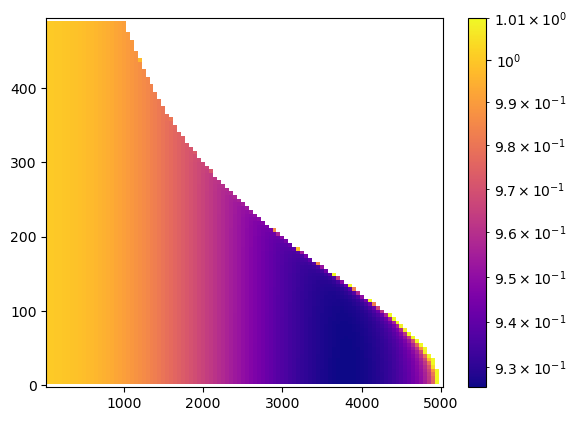

PONE


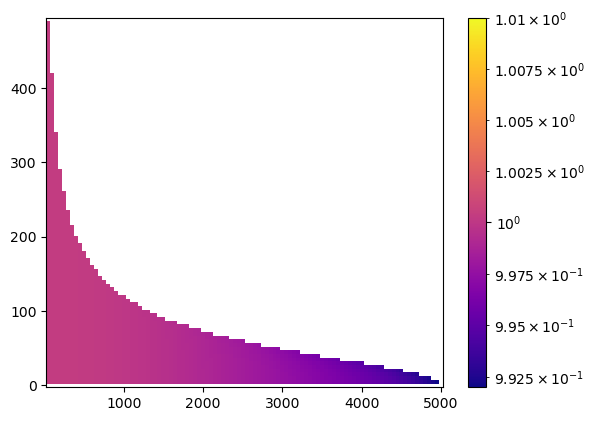

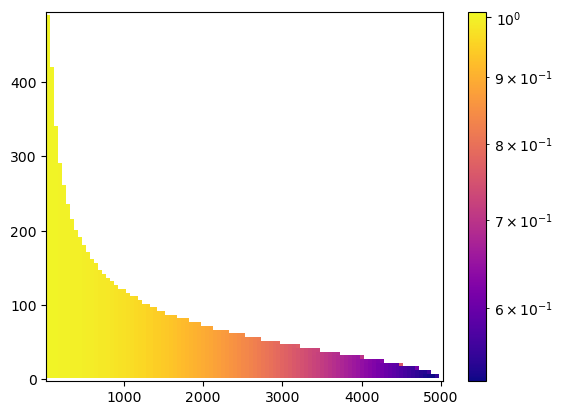

In [15]:
for experiment in experiment_list:
    numubar_ratio = numubar_rates_per_energy_radius_LV[experiment]/numubar_rates_per_energy_radius_SM[experiment]
    nue_ratio = nue_rates_per_energy_radius_LV[experiment]/nue_rates_per_energy_radius_SM[experiment]
    print(experiment)
    plt.pcolormesh(Enu,Rs,numubar_ratio.T,norm=LogNorm(vmax=1.01),cmap="plasma")
    plt.colorbar()
    plt.show()
    plt.pcolormesh(Enu,Rs,nue_ratio.T,norm=LogNorm(vmax=1.01),cmap="plasma")
    plt.colorbar()
    plt.show()